In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# アンカーボックス

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/xxx/bbox.csv')
df.head()

,name,bbox
0,r1,"[86,255,181,176]"
1,r2,"[153,107,337,311]"
2,r3,"[343,57,184,185]"
3,r4,"[238,251,173,165]"
4,r5,"[88,55,108,109]"


# アンカーボックス

In [ ]:
# アンカーボックスを定める
import os
import glob
import pandas as pd
from sklearn.cluster import KMeans

img_size = 640

bbox_dict = {'width':[] , 'height':[]}
bbox_list = []

for index, row in df.iterrows():
    bbox = row[1]
    bbox = bbox.replace('[', '')
    bbox = bbox.replace(']', '')
    bbox = bbox.split(',')

    width = float(bbox[2])
    height = float(bbox[3])

    bbox_dict['width'].append(width)
    bbox_dict['height'].append(height)

    bbox_list.append([width, height])

bbox_df = pd.DataFrame(bbox_dict)

km = KMeans(n_clusters=9,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
km_cluster = km.fit_predict(bbox_list)

bbox_df['cluster'] = km_cluster
print(bbox_df.head())

   width  height  cluster
0  181.0   176.0        4
1  337.0   311.0        3
2  184.0   185.0        6
3  173.0   165.0        4
4  108.0   109.0        5


In [ ]:
anchor_wha = {"width":[],"height":[],"area":[]}
for i in range(9):
    anchor_wha["width"].append(bbox_df[bbox_df["cluster"] == i].mean()["width"])
    anchor_wha["height"].append(bbox_df[bbox_df["cluster"] == i].mean()["height"])
    anchor_wha["area"].append(bbox_df[bbox_df["cluster"] == i].mean()["width"]*bbox_df[bbox_df["cluster"] == i].mean()["height"])


anchor_dict = pd.DataFrame(anchor_wha).sort_values('area', ascending=False)
anchor_dict["type"] = [int(img_size/32) ,int(img_size/32) ,int(img_size/32) ,  int(img_size/16) ,int(img_size/16) ,int(img_size/16) , int(img_size/8), int(img_size/8), int(img_size/8)]
print(anchor_dict)

        width  height         area  type
7  390.000000  437.00  170430.0000    20
3  337.000000  311.00  104807.0000    20
2  251.500000  372.50   93683.7500    20
8  191.750000  239.25   45876.1875    40
1  168.000000  268.00   45024.0000    40
6  175.000000  190.50   33337.5000    40
4  177.000000  170.50   30178.5000    80
0  115.000000  210.00   24150.0000    80
5  130.333333  138.00   17986.0000    80


# DataLoader

In [ ]:
# Dateset関数の実装

import os
import glob
import torch
import pathlib
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms as transforms
from torchvision.ops.boxes import box_iou

def logit(x):
    return torch.log((x + 1e-7) / (1 - x + 1e-7))

def get_image_paths_and_bbox_list(IMG_DIR, CSV_DIR):
    df = pd.read_csv(CSV_DIR)
    img_paths = []
    bbox_list = []

    img_list = []

    cls_list = []

    for index, row in df.iterrows():
        img_id = row[0]

        if "r" in row[0]:
            cls_list.append(0)
        elif "s" in row[0]:
            cls_list.append(1)
        else:
            cls_list.append(2)

        bbox = row[1]
        bbox = bbox.replace('[', '')
        bbox = bbox.replace(']', '')
        bbox = bbox.split(',')
        xmin = float(bbox[0])
        ymin = float(bbox[1])
        width = float(bbox[2])
        height = float(bbox[3])

        if img_id in img_list:
            img_index = img_list.index(img_id)

        else:
            img_list.append(img_id)
            img_path = IMG_DIR + img_id + '.jpg'
            img_paths.append(img_path)

            bbox_list.append([])
            img_index = len(bbox_list) - 1

        bbox_list[img_index].append([xmin, ymin, width, height])

    return img_paths, bbox_list, cls_list

class YOLOv3_Dataset(Dataset):
    def __init__(self, IMG_DIR, CSV_DIR, img_size_x, img_size_y, anchor_dict, trainsform=None):
        self.image_paths, self.bbox_list, self.cls_list = get_image_paths_and_bbox_list(IMG_DIR, CSV_DIR)
        self.img_size_x = img_size_x
        self.img_size_y = img_size_y
        self.anchor_dict = anchor_dict
        self.transform = transform

        # iouの計算に使用する9行4列のテンソルを作成
        # 0、1行目には矩形領域の左上のx座標とy座標（すなわち0）
        # 2、3行目には矩形領域の右下の座標（すなわちkmeans法で求めた9通りのbboxの高さと幅）が入る
        self.anchor_iou = torch.cat([torch.zeros(9,2) , torch.tensor(self.anchor_dict[["width","height"]].values)] ,dim = 1)

    def __getitem__(self, index):
        path = self.image_paths[index]
        image = Image.open(path)
        if transform is not None:
            image = self.transform(image)

        scale3_targets, scale2_targets, scale1_targets = self.get_targets(self.bbox_list[index], self.cls_list[index])

        return image, scale3_targets, scale2_targets, scale1_targets

    def __len__(self):
        return len(self.image_paths)

    def get_CxCytxty(self, bbox, anchor_idx):
        '''
        inputs
        -------
        bbox : バウンティボックスの情報[x_min, y_min, width, height]
        anchor_idx : iouでもとめた、合致するアンカーの添え字

        output
        -------
        CxCytxty : [bboxの存在するグリッドのxの位置, yの位置, tx, ty]
        '''
        grid_size_list = [32, 16, 8]  # グリッドサイズ
        grid_size = grid_size_list[int(anchor_idx/3)]

        # bboxの中心座標/グリッドサイズ
        bx = (bbox[0] + (bbox[2] // 2)) / grid_size
        by = (bbox[1] + (bbox[3] // 2)) / grid_size

        # bboxの存在するグリッドの右上の座標
        Cx = int(bx)
        Cy = int(by)

        tx = logit(torch.tensor(bx - Cx))
        ty = logit(torch.tensor(by - Cy))
        CxCytxty = [Cx, Cy, tx, ty]

        return CxCytxty

    def get_twth(self, wh, anchor_idx):
        anchor = self.anchor_dict.iloc[anchor_idx]
        Pw = anchor["width"]
        Ph = anchor["height"]
        twth = [torch.log(torch.tensor(wh[0]/Pw)), torch.log(torch.tensor(wh[1]/Ph))]

        return twth

    def get_targets(self, bbox_list, cls):

        # scale3、scale2、scale1それぞれ3つずつの0で満たされたテンソルを生成
        map_size_x = [int(self.img_size_x/32) , int(self.img_size_x/16) , int(self.img_size_x/8)]  # マップサイズ
        map_size_y = [int(self.img_size_y/32) , int(self.img_size_y/16) , int(self.img_size_y/8)]  # マップサイズ
        tensor_list = []
        for size_index in range(3):
            for _ in range(3):
                tensor_list.append(torch.zeros((4 + 1 + 3 ,map_size_y[size_index],map_size_x[size_index])))

        for bbox in bbox_list:

            # iouの計算
            # kmeansでもとめたbboxとのiouを総当たりで調べて最も値が高いbboxの添え字を取得
            label_iou = torch.cat([torch.zeros((1,2))  , torch.tensor(bbox[2:]).unsqueeze(0)],dim=1)
            iou = box_iou(label_iou, self.anchor_iou).squeeze()
            obj_idx = torch.argmax(iou).item()

            for i in range(9):
                if i == obj_idx:
                    CxCytxty = self.get_CxCytxty(bbox, i)
                    twth = self.get_twth(bbox[2:], i)

                    tensor_list[i][0,CxCytxty[1],CxCytxty[0]] = CxCytxty[2]  # tx
                    tensor_list[i][1,CxCytxty[1],CxCytxty[0]] = CxCytxty[3]  # ty
                    tensor_list[i][2,CxCytxty[1],CxCytxty[0]] = twth[0]  # tw
                    tensor_list[i][3,CxCytxty[1],CxCytxty[0]] = twth[1]  #th
                    tensor_list[i][4,CxCytxty[1],CxCytxty[0]] = 1  # 確信度
                    tensor_list[i][5 + cls,CxCytxty[1],CxCytxty[0]] = 1  # スコア

        scale3_targets = torch.cat(tensor_list[0:3] , dim = 0)
        scale2_targets = torch.cat(tensor_list[3:6] , dim = 0)
        scale1_targets = torch.cat(tensor_list[6:] , dim = 0)

        return scale3_targets, scale2_targets, scale1_targets

In [ ]:
# 教師データのDataLoaderの設定
from torch.utils.data import DataLoader

IMG_DIR = '/content/drive/My Drive/xxx/'
CSV_DIR = '/content/drive/My Drive/xxx/bbox.csv'

img_size_x = 640
img_size_y = 480
transform = transforms.ToTensor()

dataset = YOLOv3_Dataset(IMG_DIR, CSV_DIR, img_size_x, img_size_y, anchor_dict, transform)
#batch_size = 2
#train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch_size = 1

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(dataset))

print(len(train_loader))

18
18


In [ ]:
# dataloaderのテスト
mini_train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# イテレータを作成
iterator = iter(mini_train_loader)

# 1つのバッチを取り出す
img, target3, target2, target1 = next(iterator)

In [ ]:
#print(img)
print(target1)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

# 描画処理

In [ ]:
from torchvision.ops import nms

def get_bbox(tensor, x, y, grid_size, anchor):
    tx = tensor[0, y, x]
    ty = tensor[1, y, x]
    tw = tensor[2, y, x]
    th = tensor[3, y, x]

    bx = (torch.sigmoid(tx) + x) * grid_size
    by = (torch.sigmoid(ty) + y) * grid_size

    Pw = anchor["width"]
    Ph = anchor["height"]
    bw = Pw * torch.exp(tw)
    bh = Ph * torch.exp(th)

    xmin = int(bx - (bw / 2))
    if xmin < 0:
        xmin = 0
    ymin = int(by - (bh / 2))
    if ymin < 0:
        ymin = 0
    xmax = int(bx + (bw / 2))
    if xmax > 640:
        xmax = 640
    ymax = int(by + (bh / 2))
    if ymax > 480:
        ymax = 480

    return [xmin, ymin, xmax, ymax]

def get_multiple_bboxes(pred, anchor_dict, num_cls, conf_threshold=0.01):
    bbox_list = []
    conf_list = []
    label_list = []
    score_list = []
    NMS_bbox_list = []
    NMS_conf_list = []
    NMS_label_list = []
    NMS_score_list = []
    flag = False

    anchor_idx = 0
    grid_size_list = [32, 16, 8]  # グリッドサイズ
    for i, scale in enumerate(pred):
        grid_size = grid_size_list[i]
        tensor1 = scale[0:8]
        tensor2 = scale[8:16]
        tensor3 = scale[16:24]
        tensor_list = [tensor1, tensor2, tensor3]
        for tensor in tensor_list:
            conf = tensor[4, :, :]
            grid_x = int(640 / grid_size)
            grid_y = int(480 / grid_size)
            for y in range(grid_y):
                for x in range(grid_x):
                    if conf[y, x] >= conf_threshold:  # 確信度が閾値を超えた場合
                        bbox = get_bbox(tensor, x, y, grid_size, anchor_dict.iloc[anchor_idx])
                        bbox_list.append(bbox)
                        conf_list.append(conf[y, x])
                        score = 0
                        label = None
                        for cls_index in range(num_cls):
                            if score < torch.sigmoid(tensor[5 + cls_index, y, x]):
                                label = cls_index
                                score = torch.sigmoid(tensor[5 + cls_index, y, x])
                        label_list.append(label)
                        score_list.append(score)

            anchor_idx += 1

    bbox_nms_inputs = torch.tensor(bbox_list, dtype=torch.float32)
    conf_nms_inputs = torch.tensor(conf_list, dtype=torch.float32)

    # bboxを検出できなかった場合
    if bbox_nms_inputs.size(0) == 0:
        return flag, bbox_list, label_list, score_list, NMS_bbox_list, NMS_conf_list, NMS_label_list, NMS_score_list

    # 1つ以上のbboxを検出できた場合
    else:
        flag = True
        nms_idx_list = nms(bbox_nms_inputs, conf_nms_inputs, iou_threshold=0.5)

        for nms_idx in nms_idx_list:
            NMS_bbox_list.append(bbox_list[nms_idx])
            NMS_conf_list.append(conf_list[nms_idx])
            NMS_label_list.append(label_list[nms_idx])
            NMS_score_list.append(score_list[nms_idx])

        bbox_list = torch.tensor(bbox_list, dtype=torch.float32)
        label_list = torch.tensor(label_list, dtype=torch.float32)
        score_list = torch.tensor(score_list, dtype=torch.float32)
        NMS_bbox_list = torch.tensor(NMS_bbox_list, dtype=torch.float32)
        NMS_conf_list = torch.tensor(NMS_conf_list, dtype=torch.float32)
        NMS_label_list = torch.tensor(NMS_label_list, dtype=torch.float32)
        NMS_score_list = torch.tensor(NMS_score_list, dtype=torch.float32)

        #print(bbox_list.size())
        #print(NMS_bbox_list.size())

        return flag, bbox_list, label_list, score_list, NMS_bbox_list, NMS_conf_list, NMS_label_list, NMS_score_list

In [ ]:
flag, bbox_list, label_list, score_list, NMS_bbox_list, _, NMS_label_list, NMS_score_list = get_multiple_bboxes([target3[0], target2[0], target1[0]], anchor_dict, num_cls = 3)

In [ ]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as TF

def draw_bbox(img, bbox_list, cls_list=None, labels=None):
    # 前処理
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.PILToTensor()
    ])
    pil_image = transform(img)

    colors = (255, 0, 0)

    # 線の太さを指定
    line_width = 3

    if cls_list != None:
        label_list = []
        for cls in cls_list:
            label_list.append(labels[int(cls)])

        drawn_image = draw_bounding_boxes(pil_image, boxes=bbox_list, labels=label_list, colors=colors, width=line_width)
        print(label_list)
    else:
        # bboxの描画
        drawn_image = draw_bounding_boxes(pil_image, bbox_list, colors=colors, width=line_width)

    # テンソル画像をPIL画像に変換
    pil_image = TF.to_pil_image(drawn_image)

    # PIL画像を表示する
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

In [ ]:
# 閾値のみ
import matplotlib.pyplot as plt

draw_bbox(img[0], bbox_list, label_list, ["r", "s", "p"])

In [ ]:
# 非最大値抑制適応
draw_bbox(img[0], NMS_bbox_list, NMS_label_list, ["r", "s", "p"])

# モデル

In [ ]:
#Darknet53の実装

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.batchnorm import BatchNorm2d

class ResidualBlock(nn.Module):
    def  __init__(self, num_filters, num_blocks):
        super().__init__()

        self.block_list = nn.ModuleList()
        for _ in range(num_blocks):
            self.block_list.append(
               nn.Sequential(
                nn.Conv2d(num_filters, num_filters//2, 1, 1),
                nn.BatchNorm2d(num_filters//2),
                nn.LeakyReLU(),
                nn.Conv2d(num_filters//2, num_filters, 3, 1, 1),
                nn.BatchNorm2d(num_filters),
                nn.LeakyReLU()
            )
        )

    def forward(self, x):
        for block in self.block_list:
            x = x + block(x)

        return x

class Darknet53(nn.Module):
    def __init__(self):
        super(Darknet53, self).__init__()

        self.darknet26 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            ResidualBlock(64, 1),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            ResidualBlock(128, 2),

            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            ResidualBlock(256, 8)
        )

        self.darknet43 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            ResidualBlock(512, 8)
        )

        self.darknet52 = nn.Sequential(

            nn.Conv2d(512, 1024, 3, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),

            ResidualBlock(1024, 4)
        )

        self.darknet_final_layer = nn.Sequential(
            nn.Conv2d(1024, 1000, 1, 1, 0),
            nn.BatchNorm2d(1000),
            nn.LeakyReLU(),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.darknet26(x)
        x = self.darknet43(x)
        x = self.darknet52(x)
        x = self.darknet_final_layer(x)
        return x

In [ ]:
# YOLOv3の実装

class ConvBlock(nn.Module):
    def __init__(self, input_block, output_block, num_blocks):
        super(ConvBlock, self).__init__()

        conv_block = nn.ModuleList()
        for block in range(num_blocks):
            in_channels = input_block if block == 0 else output_block
            conv_block.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, output_block//2, 1, 1),
                    nn.BatchNorm2d(output_block//2),
                    nn.LeakyReLU(),
                    nn.Conv2d(output_block//2, output_block, 3, 1, 1),
                    nn.BatchNorm2d(output_block),
                    nn.LeakyReLU()
                )
            )
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.conv_block(x)

class YOLOv3(nn.Module):
    def __init__(self, num_class = 1):
        super(YOLOv3, self).__init__()

        self.darknet26 = Darknet53().darknet26
        self.darknet43 = Darknet53().darknet43
        self.darknet52 = Darknet53().darknet52

        self.conv_block = ConvBlock(1024, 1024, 3)
        self.scale3_YOLO_layer = nn.Conv2d(1024, (3 * (4 + 1 + 3)), 1, 1)

        self.scale2_upsampling = nn.Conv2d(1024, 256, 1, 1)
        self.scale2_conv_block = ConvBlock(768, 512, 3)
        self.scale2_YOLO_layer = nn.Conv2d(512, (3 * (4 + 1 + 3)), 1, 1)

        self.scale1_upsampling = nn.Conv2d(512, 128, 1, 1)
        self.scale1_conv_block = ConvBlock(384, 256, 3)
        self.scale1_YOLO_layer = nn.Conv2d(256, (3 * (4 + 1 + 3)), 1, 1)

        self.upsample = nn.Upsample(scale_factor = 2)

    def forward(self, x):
        x1 = self.darknet26(x)
        x2 = self.darknet43(x1)
        x3 = self.darknet52(x2)

        x3 = self.conv_block(x3)
        scale3_output = self.scale3_YOLO_layer(x3)

        scale2_upsample = self.upsample(self.scale2_upsampling(x3))
        x2 = torch.cat((x2, scale2_upsample), dim=1)
        x2 = self.scale2_conv_block(x2)
        scale2_output = self.scale2_YOLO_layer(x2)

        scale1_upsample = self.upsample(self.scale1_upsampling(x2))
        x1 = torch.cat((x1, scale1_upsample), dim=1)
        x1 = self.scale1_conv_block(x1)
        scale1_output = self.scale1_YOLO_layer(x1)

        return scale3_output, scale2_output, scale1_output

In [ ]:
YOLOv3()

YOLOv3(
  (darknet26): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ResidualBlock(
      (block_list): ModuleList(
        (0): Sequential(
          (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (7): Conv2d(64, 128, 

In [ ]:
# テスト
model = YOLOv3()
with torch.no_grad():
    output = model(torch.zeros((1,3,640,480)))
for i in range(3):
    print(output[i].shape)

torch.Size([1, 24, 20, 15])
torch.Size([1, 24, 40, 30])
torch.Size([1, 24, 80, 60])


# 学習の実行

In [ ]:
# 損失関数の実装
def YOLOv3_loss_function(pred_list, targets_list, lambda_coord=0.1, lambda_obj=1.0, lambda_class=1.0, lambda_noobj=0.01):

    coord_loss = 0
    obj_loss = 0
    class_loss = 0
    noobj_loss = 0

    B = pred_list[0].size(0)

    for i in range(3):
        pred = pred_list[i]
        targets = targets_list[i]
        for j in range(3):
            pred_cut = pred[:, j*(4+1+3):(j+1)*(4+1+3), :, :]  # predの分割
            pred_boxes = pred_cut[:, :4, :, :]  # 予測されたbboxの座標 (tx, ty, tw, th)
            pred_conf_obj = pred_cut[:, 4, :, :].unsqueeze(dim=1)  # 予測されたbboxの確信度
            pred_classes = pred_cut[:, 5:, :, :]  # クラスのスコア

            targets_cut = targets[:, j*(4+1+3):(j+1)*(4+1+3), :, :]  # targetsの分割
            targets_boxes = targets_cut[:, :4, :, :]  # targetsのbboxの座標 (tx, ty, tw, th)
            targets_obj_mask = targets_cut[:, 4, :, :].unsqueeze(dim=1)  # オブジェクトマスク
            targets_classes = targets_cut[:, 5:, :, :]  # targetsのスコア

            # 位置の損失を計算
            #coord_loss += lambda_coord * nn.MSELoss(reduction='sum')(targets_obj_mask * pred_boxes, targets_boxes)
            coord_loss += lambda_coord * torch.sum(torch.square(pred_boxes - targets_boxes) * targets_obj_mask)

            # オブジェクトの損失を計算
            #obj_loss += lambda_obj * nn.BCEWithLogitsLoss(reduction='sum')(targets_obj_mask * pred_conf_obj, targets_obj_mask)
            obj_loss += lambda_obj * torch.sum(-1 * torch.log(torch.sigmoid(pred_conf_obj)+ 1e-7) * targets_obj_mask)

            # クラスの損失を計算
            class_loss += lambda_class * torch.sum(targets_obj_mask * F.binary_cross_entropy(torch.sigmoid(pred_classes), targets_classes))

            # ノンオブジェクトの損失を計算
            #noobj_loss += lambda_noobj * nn.BCEWithLogitsLoss(reduction='sum')((1 - targets_obj_mask) * (1 - pred_conf_obj), 1 - targets_obj_mask)
            noobj_loss += lambda_noobj * torch.sum((-1 * torch.log(1 - torch.sigmoid(pred_conf_obj)+ 1e-7)) * (1 - targets_obj_mask))

    loss = coord_loss + obj_loss + class_loss + noobj_loss

    return loss/B, coord_loss/B, obj_loss/B, class_loss/B, noobj_loss/B

In [ ]:
from torch import optim

# モデル
model = YOLOv3()
#model.load_state_dict(torch.load('./YOLOv3_weights_e100.pth'))
model.cuda()

# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters())

# エポック数
epoch = 100

In [ ]:
# 損失のログ
record_loss_train = []
record_loss_test = []

for i in range(epoch):
    model.train()
    loss_train = 0
    coord_loss_train = 0
    obj_loss_train = 0
    class_loss_train = 0
    noobj_loss_train = 0
    for j, (img, target3, target2, target1) in enumerate(train_loader):
        img, target3, target2, target1 = img.cuda(), target3.cuda(), target2.cuda(), target1.cuda()  # GPU対応
        pred3, pred2, pred1 = model(img)
        #print(pred3.size())
        #print(target3.size())
        loss, coord_loss, obj_loss, class_loss, noobj_loss= YOLOv3_loss_function([pred3, pred2, pred1], [target3, target2, target1])
        loss_train += loss.item()
        coord_loss_train += coord_loss.item()
        obj_loss_train += obj_loss.item()
        class_loss_train += class_loss.item()
        noobj_loss_train += noobj_loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    coord_loss_train /= j+1
    obj_loss_train /= j+1
    class_loss_train /= j+1
    noobj_loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:",round(loss_train, 3), "coord_loss_train", round(coord_loss_train, 3), "obj_loss_train", round(obj_loss_train, 3), "class_loss_train", round(class_loss_train, 3), "noobj_loss_train", round(noobj_loss_train, 3))


Epoch: 0 Loss_Train: 56.64 coord_loss_train 2.494 obj_loss_train 1.932 class_loss_train 0.602 noobj_loss_train 51.611
Epoch: 1 Loss_Train: 17.03 coord_loss_train 2.381 obj_loss_train 2.961 class_loss_train 0.277 noobj_loss_train 11.411
Epoch: 2 Loss_Train: 8.871 coord_loss_train 1.034 obj_loss_train 2.631 class_loss_train 0.152 noobj_loss_train 5.054
Epoch: 3 Loss_Train: 6.359 coord_loss_train 0.364 obj_loss_train 2.643 class_loss_train 0.094 noobj_loss_train 3.258
Epoch: 4 Loss_Train: 5.257 coord_loss_train 0.275 obj_loss_train 2.221 class_loss_train 0.066 noobj_loss_train 2.695
Epoch: 5 Loss_Train: 4.754 coord_loss_train 0.811 obj_loss_train 1.833 class_loss_train 0.049 noobj_loss_train 2.061
Epoch: 6 Loss_Train: 3.955 coord_loss_train 0.231 obj_loss_train 1.843 class_loss_train 0.036 noobj_loss_train 1.845
Epoch: 7 Loss_Train: 3.734 coord_loss_train 0.562 obj_loss_train 1.551 class_loss_train 0.03 noobj_loss_train 1.592
Epoch: 8 Loss_Train: 3.178 coord_loss_train 0.198 obj_loss_trai

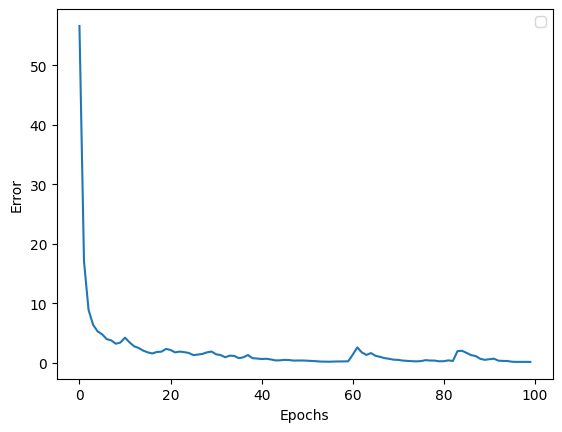

In [ ]:
# 誤差の推移
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train)
#plt.plot(range(len(record_loss_test)), record_loss_test)
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
model.eval()

transform = transforms.ToTensor()

image = Image.open('/content/drive/My Drive/xxx/xxx.jpg')
image = transform(image)
#print(image.unsqueeze(dim=0).size())
pred3, pred2, pred1 = model(image.unsqueeze(dim=0).cuda())
#print(pred3)
#bbox_list, NMS_bbox_list, _, f= get_multiple_bboxes([pred3[0], pred2[0], pred1[0]], anchor_dict, 1024, 0)
flag, bbox_list, label_list, score_list, NMS_bbox_list, _, NMS_label_list, NMS_score_list = get_multiple_bboxes([pred3[0], pred2[0], pred1[0]], anchor_dict, num_cls = 3)
print(flag)
if flag == True:
    draw_bbox(image, bbox_list)
    draw_bbox(image, NMS_bbox_list)
    print(NMS_label_list)
    print(NMS_score_list)

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/xxx/xxx.pth')